# CMA/ES. Paper repro 8th try: LL92, fixed cov

LL92, trying to see if the optimal parameters of the paper come out?

Wonder why they don't though.

In [103]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [104]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sys
from IPython.utils import io


from experimentlauncher import ExperimentLauncher
from dataio import DataIO
import plots_experimental_data
import em_circularmixture_parametrickappa


# import matplotlib.animation as plt_anim
from mpl_toolkits.mplot3d import Axes3D

import re
import inspect
import imp

import utils
# import submitpbs
import load_experimental_data

from plots_fitexperiment_papertheo import PlotsFitExperimentAllTPaperTheo

## Reload data

In [105]:
%cd /nfs/data3/lmatthey/visual_working_mem/fitexperiment_sigmabaseline_cmaes_08_2016/cmaes_bays09_ll92_8try_Mratiosigmax_repetitions3_220816
results_optim_tracking = np.load('outputs/cmaes_alliter_tracking-<module>-06c2a1f8-fbf8-4f58-8dd6-57e748c002fe.npy').item()

/nfs/data3/lmatthey/visual_working_mem/fitexperiment_sigmabaseline_cmaes_08_2016/cmaes_bays09_ll92_8try_Mratiosigmax_repetitions3_220816


In [106]:
candidates_parameters = np.array(results_optim_tracking['candidates'])
fitness = np.array(results_optim_tracking['fitness'])
parameter_names_sorted = results_optim_tracking['parameter_names_sorted']

In [107]:
parameter_names_sorted

['M', 'ratio_conj', 'sigmax']

In [108]:
metric = 'dist_nll92'

df_all_fits = pd.DataFrame.from_items([('step', np.arange(fitness.size)), 
                                       (metric, np.ma.masked_greater(fitness.flatten(), 1e8))] + 
                                      [(param, candidates_parameters[:, param_i]) 
                                           for param_i, param in enumerate(parameter_names_sorted)])

In [109]:
# Fix M and ratio_conj
M_corrected, ratio_corrected = utils.fix_M_ratioconj(df_all_fits['M'], df_all_fits['ratio_conj'])
df_all_fits.loc[:, 'M'] = M_corrected
df_all_fits.loc[:, 'ratio_conj'] = ratio_corrected

In [110]:
# Filter rows where LL > cutoff value and remove lapse_rate > cutoff
LL_max_cutoff = 20000

df_best_fits = df_all_fits[df_all_fits[metric] < LL_max_cutoff]

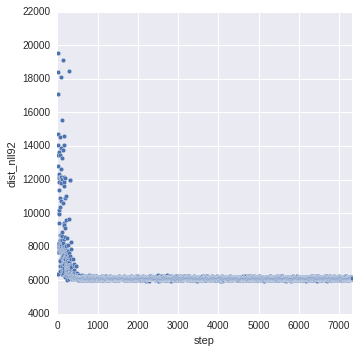

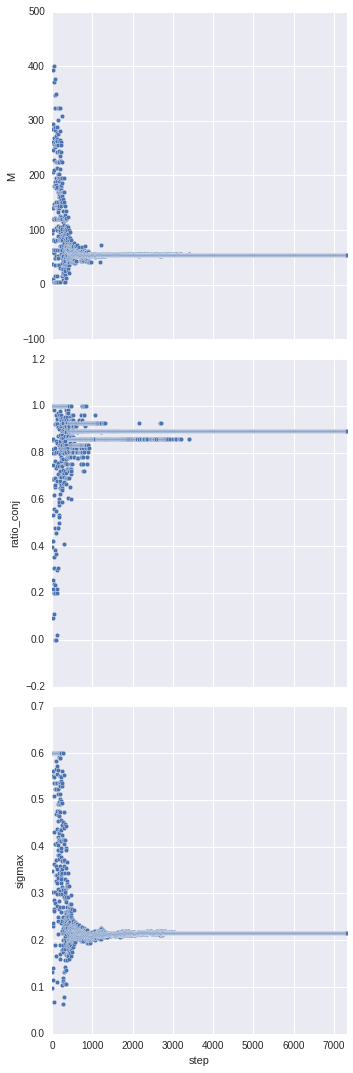

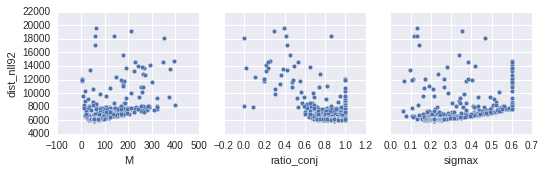

In [111]:
# Learning curve
g = sns.pairplot(df_best_fits,
             y_vars=[metric],
             x_vars=['step'],
             size=5
            )
g.set(xlim=(-1, df_best_fits['step'].max())
     )


# Check training of parameters
g = sns.pairplot(df_best_fits,
             y_vars=parameter_names_sorted,
             x_vars=['step'],
             size=5
            )
g.set(xlim=(-1, df_best_fits['step'].max()))


# Check parameters effects
sns.pairplot(df_best_fits,
             x_vars=parameter_names_sorted,
             y_vars=[metric],
            )



## Check parameters values obtained

In [119]:
df_bestparams = df_best_fits.sort_values(by='step', ascending=False).head(100).median()
print df_bestparams
df_bestparams_paper = dict(M=144, ratio_conj=0.84, sigmax=0.2)
print df_bestparams_paper

step          7269.500000
dist_nll92    6120.698752
M               55.000000
ratio_conj       0.890909
sigmax           0.215980
dtype: float64
{'ratio_conj': 0.84, 'M': 144, 'sigmax': 0.2}


In [121]:
experiment_parameters = dict(action_to_do='launcher_do_fitexperiment_allmetrics',
                             inference_method='none',
                             experiment_id='bays09',
                             selection_method='last',
                             renormalize_sigma=None,
                             sigmay=0.00001,
                             num_samples=50,
                             code_type='mixed',
                             slice_width=0.07,
                             burn_samples=100,
                             ratio_conj=0.7,
                             filter_datapoints_size=1000,
                             filter_datapoints_selection='random',
                             stimuli_generation_recall='random',
                             autoset_parameters=None,
                             )

experiment_parameters.update(df_bestparams_paper)
for key in ['M']:
    experiment_parameters[key] = int(experiment_parameters[key])

with io.capture_output(stdout=False, display=False) as captured:
    experiment_launcher = ExperimentLauncher(run=True, arguments_dict=experiment_parameters)
    fit_exp = experiment_launcher.all_vars['fit_exp']
    plots_fit_exp = PlotsFitExperimentAllTPaperTheo(fit_exp)

Arguments: ['-f', '/run/user/5201/jupyter/kernel-140e0c0f-0b57-41b7-ac6a-d9282bc9ea6b.json']

        Given a single experiment_id, will run the model on all T in the experimental data.
        Computes several metrics (LL, BIC) and can additionally sample from the model and check the Mixture model
        summary statistics fits.

        If inference_method is not none, also fits a EM mixture model, get the precision and the fisher information
    
Doing a piece of work for launcher_do_fitexperimentsinglet
{'M_layer_one': 400, 'code_type': 'mixed', 'verbose': False, 'selection_num_samples': 1, 'subaction': '', 'load_all_from_parameters_file': False, 'pylab': True, 'specific_stimuli_random_centers': False, 'enforce_min_distance': 0.17, 'result_computation': '', 'threshold': 0.0, 'slice_width': 0.07, 'rc_scale': 0.5, 'autoset_parameters': True, 'job_name': '', 'experiment_data_dir': '../../experimental_data/', 'normalise_weights': 1, 'use_theoretical_cov': False, 'best_parameters_file'

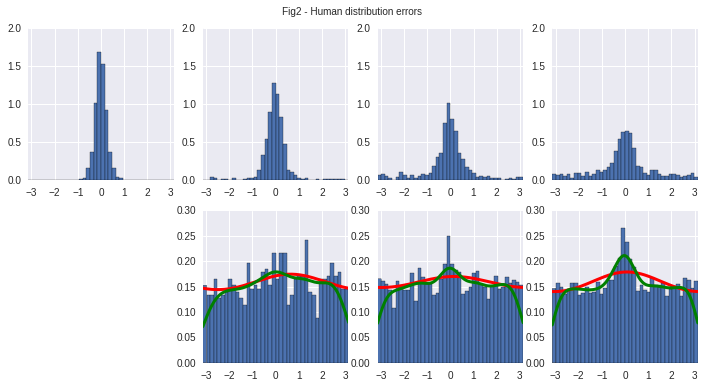

In [122]:
with io.capture_output(display=False) as captured:
    axesFig2 = plots_fit_exp.plots_distrib_errors_data_fig2()

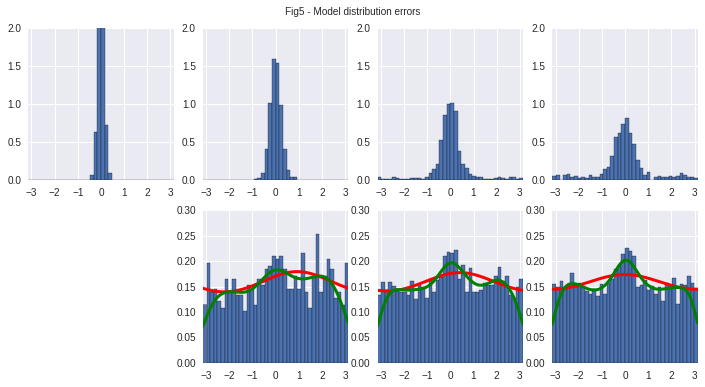

In [123]:
with io.capture_output(display=False) as captured:
    axesFig5 = plots_fit_exp.plots_distrib_errors_fig5()

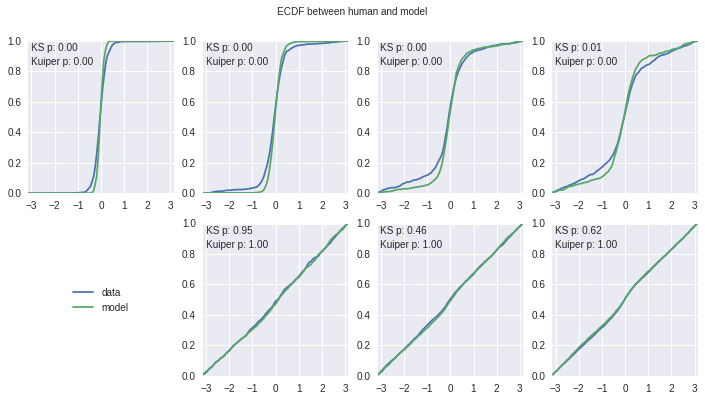

In [124]:
with io.capture_output(display=False) as captured:
    axes, _ = plots_fit_exp.plots_KS_comparison_fig2fig5(bins=100)

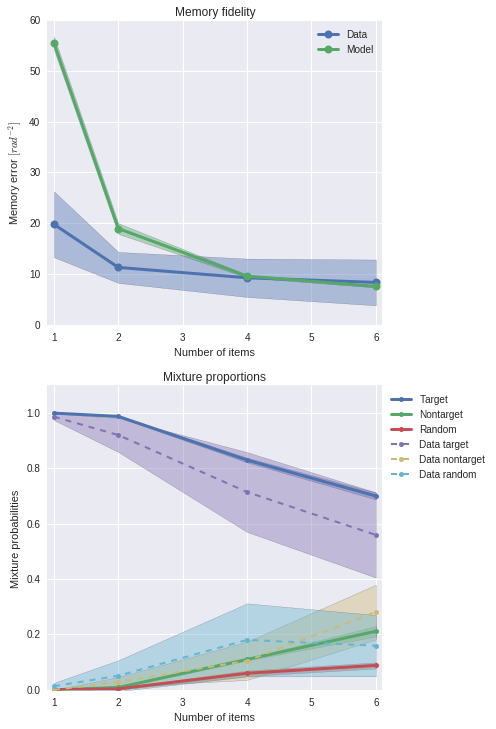

In [125]:
with io.capture_output(display=False) as captured:
    axesFig6Fig13 = plots_fit_exp.plots_memmixtcurves_fig6fig13(num_repetitions=1, use_cache=True)

# ANALYSE ME

Paper used M=144, ratio=0.85, sigma_x = 0.1 (sigma_x changed meaning :/)